# HW2-3: SIFT 特征点检测与描述的实现，及其简单应用（65分）
- SIFT（Scale-Invariant Feature Transform）是一种用于图像处理的算法，用于检测和描述图像中的局部特征。
- SIFT 算法的主要特点是对图像的尺度、旋转和亮度变化具有不变性。
- SIFT 算法的主要步骤包括尺度空间极值检测、关键点定位、方向确定、关键点描述等。
- 参考资料1: https://blog.csdn.net/weixin_48167570/article/details/123704075 （建议同学们认真学习）
- 参考资料2: https://zhuanlan.zhihu.com/p/462061756 （建议同学们认真学习）

本次作业将带着同学们使用 Python 实现 SIFT 算法的关键步骤，包括DoG图像金字塔的构建, SIFT描述子的构建和SIFT整体流程的实现。
并且，我们将使用实现的 SIFT 算法在两幅图像中检测特征点，并进行特征点匹配，最终实现简单的图像拼接。

---
## 第一部分：DoG图像金字塔的构建 (15分)

- SIFT算法对特征点的检测是基于图像的尺度空间的极值点检测，为了检测不同尺度下的特征点，SIFT算法首先需要构建图像的高斯金字塔，然后通过高斯金字塔构建高斯差分金字塔（DoG金字塔）。

- 在下面的代码块中，我们会先实现高斯金字塔的构建（**其中需要同学们补全部分代码**），然后**需要同学们在此基础上实现高斯差分金字塔的构建**。

- 评分标准：
    - 高斯金字塔的代码补全正确：5'
    - 高斯差分金字塔构建正确：5'
    - 高斯差分金字塔的展示：5' (请展示在notebook的输出中)

In [1]:
"""此处是本次作业需要用到的模块，在第一次作业装好的环境下即可运行"""
import numpy as np
import cv2
import os
from functools import cmp_to_key

"""Global Variables | 本次作业需要的全局变量"""
ini_sigma = 1.6 # initial sigma of sift ｜ sift的初始sigma
num_intervals = 3 # number of intervals in each octave of scale space ｜ 每个octave中的层数
assumed_blur = 0.5 # amount of assumed image blurring ｜ 假设相机造成的图像模糊程度
image_border_width = 5 # width of the border at which to exclude keypoints ｜ 排除边界的宽度
contrast_threshold = 0.04 # threshold on keypoint contrast, from openCV ｜ 关键点对比度的阈值
float_tolerance = 1e-7 # tolerance for checking float values ｜ 浮点数的容差

In [2]:
""" Construction of Gaussian pyramid | 高斯金字塔的构建 """
# 此处代码仅需要补全一小部分
# 补全后，你可以直接调用这个函数来为图像生成高斯金字塔

def generate_gaussian_pyramid(image):
    """Generate a Gaussian pyramid
    Args:
        image: 2D array representing the input image - grayscale, np.array
    Returns:
        gaussian_pyramid: np.array, shape (num_octaves, num_images_per_octave, H, W)
    """
    # 0. check input image
    assert len(image.shape) == 2, 'image must be grayscale'
    assert image.dtype == 'float32', 'image must be float32'

    # 1. generate base image: resize to double & apply Gaussian blur
    base_img = cv2.resize(image, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    sigma_diff = np.sqrt(max((ini_sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    base_img = cv2.GaussianBlur(base_img, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)

    # 2. generate Gaussian pyramid
    
    # 2.1 calculate number of octaves
    num_octaves = int(np.log(min(base_img.shape[0], base_img.shape[1])) / np.log(2))
    print(f"number of octaves of Gaussian pyramid: {num_octaves}")
    print("-" * 10)
    
    # 2.2 initialize Gaussian kernals
    num_images_per_octave = num_intervals + 3 # there are num_intervals + 3 images per octave, while keypoints are detected in (num_intervals) images per octave
    k = 2 ** (1. / num_intervals) # constant factor by which the blur is multiplied when moving to the next level within an octave
    gaussian_kernels = np.zeros(num_images_per_octave)  # scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels[0] = ini_sigma
    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * ini_sigma
        sigma_total = sigma_previous * k
        gaussian_kernels[image_index] = np.sqrt(sigma_total ** 2 - sigma_previous ** 2)
    print(f"got {num_images_per_octave} Gaussian kernels: {gaussian_kernels}")
    print("-" * 10)

    # 2.3 Gaussian pyramids generation starts
    gaussian_pyramid = []
    temp_image = base_img
    for _ in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(temp_image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            temp_image = cv2.GaussianBlur(temp_image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(temp_image)
        gaussian_pyramid.append(gaussian_images_in_octave)

        # ======================================== TODO
        # the next two line is to generate the next octave, which is the base image for the next octave
        temp_index = - 3 # TODO: please figure out this index, which is the image index of the base image in the next octave
        octave_base = gaussian_images_in_octave[temp_index]
        # ======================================== TODO

        temp_image = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=cv2.INTER_NEAREST)
    gaussian_pyramid = np.array(gaussian_pyramid, dtype=object)
    print(f"got {len(gaussian_pyramid)} octaves in Gaussian pyramid, and each octave has {len(gaussian_pyramid[0])} images")
    print("-" * 10)

    return gaussian_pyramid

- 请你确定上述代码中的 temp_index（TODO标识的部分）的值是多少？并在代码中填写上正确的值。
- 提示: 你可以在参考资料中找到答案（以参考资料为准，PPT中需要勘误）

In [3]:
""" Save the Gaussian pyramid | 保存高斯金字塔 """
# 你可以调用这个函数来保存高斯金字塔的图像，以便于你的调试
# 该函数返回一个字典, 字典的键是图像在高斯金字塔中的位置，值是代表图像的numpy数组
# 你也可以利用这个函数的返回值显示高斯金字塔的图像
def save_gaussian_pyramid(gaussian_pyramid, out_folder=None):
    gaussian_pyramid_images = {}
    if out_folder is not None:
        if not os.path.exists(out_folder):
            os.makedirs(out_folder)
            print(f"saved Gaussian pyramid to {out_folder}")

    for i, octave in enumerate(gaussian_pyramid):
        for j, img in enumerate(octave):
            if out_folder is not None:
                img_name = f"gaussian_octave_{i}_image_{j}"
                img_path = os.path.join(out_folder, img_name+".jpg")
                cv2.imwrite(img_path, img)
            
            gaussian_pyramid_images[f"octave_{i}_image_{j}"] = img


    return gaussian_pyramid_images

- 在上述两个代码块成功运行后，你应该可以利用`generate_gaussian_pyramid`函数为输入图像构建出它的高斯金字塔，并且在此基础上进一步构建出图像的高斯差分金字塔。

- 请在下面的代码块中完成高斯差分金字塔的构建（以函数形式），并调用你的函数，**保存并展示高斯差分图像**，检查你的实现是否正确。

- 要求
    - **输出的正确性**：该函数的输入参数为高斯金字塔的图像列表，输出为高斯差分金字塔的图像列表。**注意**：类型为np.array，形状为 (octave数, 每个octave的尺度数-1, 图像高度, 图像宽度)。
    - 提示: 你可以先用列表存储每个octave内的高斯差分图像，然后再转换为np.array类型。
    - **展示**：请按顺序展示高斯差分金字塔的图像列表（建议拼成一个大图后用cv2.imshow展示），以便检查你的实现是否正确。

In [4]:
""" Construction of Difference-of-Gaussians image pyramid | 差分高斯金字塔的构建 """
def generate_DoG_pyramid(gaussian_pyramid):
    """Generate Difference-of-Gaussians image pyramid
    TODO: implement the function to generate DoG pyramid | 实现生成DoG金字塔的函数
    Args:
        gaussian_pyramid: Gaussian pyramid, np.array, shape (num_octaves, num_images_per_octave, H, W)
    Returns:
        dog_pyramid: Difference-of-Gaussians image pyramid, np.array, shape (num_octaves, num_images_per_octave-1, H, W)
    """
    dog_pyramid = []
    for octave in gaussian_pyramid:
        octave_dog = []
        for i in range(len(octave)-1):
            dog = octave[i+1] - octave[i]
            octave_dog.append(dog)
        dog_pyramid.append(octave_dog)
    dog_pyramid = np.array(dog_pyramid, dtype=object)
    
    return dog_pyramid

接下来，请你在下面的代码块中试试看你的代码，看看你的高斯差分金字塔是否构建正确。
并在输出中展示高斯差分金字塔的图像。（using cv2.imshow etc.）

number of octaves of Gaussian pyramid: 10
----------
got 6 Gaussian kernels: [1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]
----------
got 10 octaves in Gaussian pyramid, and each octave has 6 images
----------


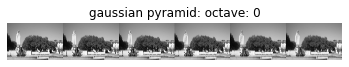

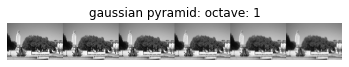

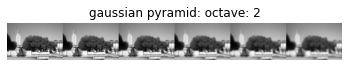

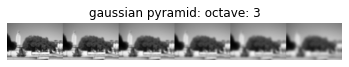

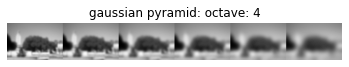

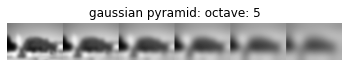

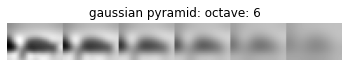

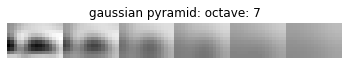

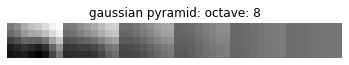

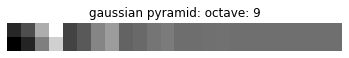

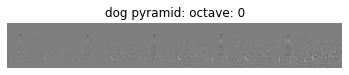

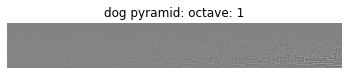

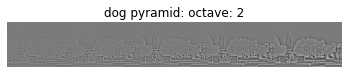

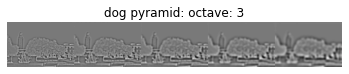

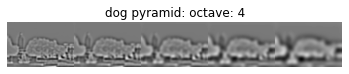

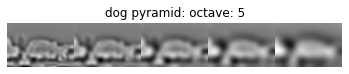

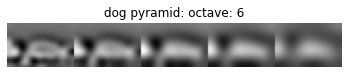

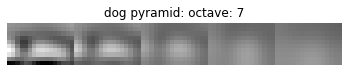

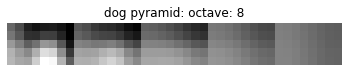

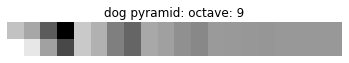

In [5]:
"""evaluate your DoG pyramid | 评估你实现的DoG金字塔生成"""

# 1. load the image TODO: change the path to your image and output folder | 加载图像与输出文件夹
img_path = "HW2-data/left.JPG"
out_folder = "output"

# 2. convert the image to grayscale
img = cv2.imread(img_path)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_img = gray_img.astype(np.float32)

# 3. generate Gaussian pyramid
gaussian_pyramid = generate_gaussian_pyramid(gray_img)

# 4. save the Gaussian pyramid TODO: you can modify this function to display the Gaussian pyramid directly | 保存并展示高斯金字塔
save_gaussian_pyramid(gaussian_pyramid, "gaussian_pyramid")

## TODO: show them!
import matplotlib.pyplot as plt
# use CV2 to show the Gaussian pyramid, by octave order. First combine all the images into a single image, then show them


for i, octave in enumerate(gaussian_pyramid):
    combined_img = np.hstack(octave)
    plt.imshow(combined_img, cmap='gray')
    plt.title("gaussian pyramid: octave: " + str(i))
    plt.axis('off')
    plt.show()

# 5. generate Difference-of-Gaussians image pyramid TODO: implement this function | 生成DoG金字塔
dog_pyramid = generate_DoG_pyramid(gaussian_pyramid)

# 6. show the Difference-of-Gaussians image pyramid TODO: show them in order! | 展示DoG金字塔

for i, octave in enumerate(dog_pyramid):
    combined_img = np.hstack(octave)
    plt.imshow(combined_img, cmap='gray')
    plt.title("dog pyramid: octave: " + str(i))
    plt.axis('off')
    plt.show()



---

# 第二部分：SIFT关键点的检测（5分）

假设我们已经构建好了高斯差分金字塔，接下来我们需要在高斯差分金字塔中检测极值点，这些极值点就是我们的关键点。

- 在下面的代码块中，我们会实现SIFT的关键点检测的绝大部分（由于代码过于复杂），但是需要同学们阅读并理解代码，然后**补充其中的关键步骤**。

- 评分标准：
    - 关键点检测的代码补全正确：5'

In [6]:
from tqdm import tqdm
class KeyPointsFinder(object):
    """
    """
    def __init__(self, image, gaussian_pyramid, dog_pyramid, output_folder=None) -> None:
        self.image = image
        self.gaussian_pyramid = gaussian_pyramid
        self.dog_pyramid = dog_pyramid
        self.output_folder = output_folder

    # main function for finding keypoints
    def find_keypoints(self):
        """Find pixel positions of all scale-space extrema in the image pyramid
        """
        gaussian_pyramid = self.gaussian_pyramid
        dog_pyramid = self.dog_pyramid
        threshold = np.floor(0.5 * contrast_threshold / num_intervals * 255)  # from OpenCV implementation
        keypoints = []

        for octave_index, dog_images_in_octave in tqdm(enumerate(dog_pyramid), desc="calculating keypoints in each octave", total = len(dog_pyramid)):
            for image_index, (first_image, second_image, third_image) in tqdm(enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])),total=(len(dog_images_in_octave)-2)):
                # (i, j) is the center of the 3x3 array
                for i in range(image_border_width, first_image.shape[0] - image_border_width):
                    for j in range(image_border_width, first_image.shape[1] - image_border_width):
                        if self.isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                            localization_result = self.localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, ini_sigma, contrast_threshold, image_border_width)
                            if localization_result is not None:
                                keypoint, localized_image_index = localization_result
                                keypoints_with_orientations = self.computeKeypointsWithOrientations(keypoint, octave_index, gaussian_pyramid[octave_index][localized_image_index])
                                for keypoint_with_orientation in keypoints_with_orientations:
                                    keypoints.append(keypoint_with_orientation)

        keypoints = self.removeDuplicateKeypoints(keypoints)
        keypoints = self.convertKeypointsToInputImageSize(keypoints)
        return keypoints

    # TODO: 需要补充的代码块在该函数中
    def computeKeypointsWithOrientations(self, keypoint, octave_index, gaussian_pyramid, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
        """Compute orientations for each keypoint
        """
        keypoints_with_orientations = []
        image_shape = gaussian_pyramid.shape

        scale = scale_factor * keypoint.size / np.float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
        radius = int(np.round(radius_factor * scale))
        weight_factor = -0.5 / (scale ** 2)
        raw_histogram = np.zeros(num_bins)
        smooth_histogram = np.zeros(num_bins)

        """TODO: 需要补充的代码块开始"""
        for i in range(-radius, radius + 1):
            region_y = int(np.round(keypoint.pt[1] / np.float32(2 ** octave_index))) + i
            if region_y > 0 and region_y < image_shape[0] - 1:
                for j in range(-radius, radius + 1):
                    region_x = int(np.round(keypoint.pt[0] / np.float32(2 ** octave_index))) + j
                    if region_x > 0 and region_x < image_shape[1] - 1:
                        dx = gaussian_pyramid[region_y, region_x + 1] - gaussian_pyramid[region_y, region_x - 1]
                        dy = gaussian_pyramid[region_y - 1, region_x] - gaussian_pyramid[region_y + 1, region_x]
                        gradient_magnitude = np.sqrt(dx*dx + dy*dy) # TODO: 用合适的代码计算梯度幅值
                        gradient_orientation = np.arctan(dy/(dx + 1e-9)) # TODO: 用合适的代码计算梯度方向，单位是角度， 提示：你可以用numpy的库函数
                        weight = np.exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                        histogram_index = int(np.round(gradient_orientation * num_bins / 360.))
                        raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude
        """TODO: 需要补充的代码块结束"""

        for n in range(num_bins):
            smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
        orientation_max = max(smooth_histogram)
        orientation_peaks = np.where(np.logical_and(smooth_histogram > np.roll(smooth_histogram, 1), smooth_histogram > np.roll(smooth_histogram, -1)))[0]
        for peak_index in orientation_peaks:
            peak_value = smooth_histogram[peak_index]
            if peak_value >= peak_ratio * orientation_max:
                # Quadratic peak interpolation
                # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
                left_value = smooth_histogram[(peak_index - 1) % num_bins]
                right_value = smooth_histogram[(peak_index + 1) % num_bins]
                interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
                orientation = 360. - interpolated_peak_index * 360. / num_bins
                if abs(orientation - 360.) < float_tolerance:
                    orientation = 0
                new_keypoint = cv2.KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
                keypoints_with_orientations.append(new_keypoint)
        return keypoints_with_orientations

    def isPixelAnExtremum(self, first_subimage, second_subimage, third_subimage, threshold):
        """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
        """
        center_pixel_value = second_subimage[1, 1]
        if np.abs(center_pixel_value) > threshold:
            if center_pixel_value > 0:
                return np.all(center_pixel_value >= first_subimage) and \
                    np.all(center_pixel_value >= third_subimage) and \
                    np.all(center_pixel_value >= second_subimage[0, :]) and \
                    np.all(center_pixel_value >= second_subimage[2, :]) and \
                    center_pixel_value >= second_subimage[1, 0] and \
                    center_pixel_value >= second_subimage[1, 2]
            elif center_pixel_value < 0:
                return np.all(center_pixel_value <= first_subimage) and \
                    np.all(center_pixel_value <= third_subimage) and \
                    np.all(center_pixel_value <= second_subimage[0, :]) and \
                    np.all(center_pixel_value <= second_subimage[2, :]) and \
                    center_pixel_value <= second_subimage[1, 0] and \
                    center_pixel_value <= second_subimage[1, 2]
        return False

    def localizeExtremumViaQuadraticFit(self, i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
        """Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbors
        """
        extremum_is_outside_image = False
        image_shape = dog_images_in_octave[0].shape
        for attempt_index in range(num_attempts_until_convergence):
            # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
            first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
            pixel_cube = np.stack([first_image[i-1:i+2, j-1:j+2],
                                second_image[i-1:i+2, j-1:j+2],
                                third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
            gradient = self.computeGradientAtCenterPixel(pixel_cube)
            hessian = self.computeHessianAtCenterPixel(pixel_cube)
            extremum_update = -np.linalg.lstsq(hessian, gradient, rcond=None)[0]
            if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
                break
            j += int(np.round(extremum_update[0]))
            i += int(np.round(extremum_update[1]))
            image_index += int(np.round(extremum_update[2]))
            # make sure the new pixel_cube will lie entirely within the image
            if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
                extremum_is_outside_image = True
                break
        if extremum_is_outside_image:
            return None
        if attempt_index >= num_attempts_until_convergence - 1:
            return None
        functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * np.dot(gradient, extremum_update)
        if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
            xy_hessian = hessian[:2, :2]
            xy_hessian_trace = np.trace(xy_hessian)
            xy_hessian_det = np.linalg.det(xy_hessian)
            if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
                # Contrast check passed -- construct and return OpenCV KeyPoint object
                keypoint = cv2.KeyPoint()
                keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
                keypoint.octave = octave_index + image_index * (2 ** 8) + int(np.round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
                keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / np.float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
                keypoint.response = abs(functionValueAtUpdatedExtremum)
                return keypoint, image_index
        return None

    def computeGradientAtCenterPixel(self, pixel_array):
        """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
        """
        # With step size h, the central difference formula of order O(h^2) for f'(x) is (f(x + h) - f(x - h)) / (2 * h)
        # Here h = 1, so the formula simplifies to f'(x) = (f(x + 1) - f(x - 1)) / 2
        # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
        dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
        dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
        ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
        return np.array([dx, dy, ds])

    def computeHessianAtCenterPixel(self, pixel_array):
        """Approximate Hessian at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
        """
        # With step size h, the central difference formula of order O(h^2) for f''(x) is (f(x + h) - 2 * f(x) + f(x - h)) / (h ^ 2)
        # Here h = 1, so the formula simplifies to f''(x) = f(x + 1) - 2 * f(x) + f(x - 1)
        # With step size h, the central difference formula of order O(h^2) for (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
        # Here h = 1, so the formula simplifies to (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
        # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
        center_pixel_value = pixel_array[1, 1, 1]
        dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
        dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
        dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
        dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
        dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
        dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
        return np.array([[dxx, dxy, dxs], 
                    [dxy, dyy, dys],
                    [dxs, dys, dss]])

    def compareKeypoints(self, keypoint1, keypoint2):
        """Return True if keypoint1 is less than keypoint2
        """
        if keypoint1.pt[0] != keypoint2.pt[0]:
            return keypoint1.pt[0] - keypoint2.pt[0]
        if keypoint1.pt[1] != keypoint2.pt[1]:
            return keypoint1.pt[1] - keypoint2.pt[1]
        if keypoint1.size != keypoint2.size:
            return keypoint2.size - keypoint1.size
        if keypoint1.angle != keypoint2.angle:
            return keypoint1.angle - keypoint2.angle
        if keypoint1.response != keypoint2.response:
            return keypoint2.response - keypoint1.response
        if keypoint1.octave != keypoint2.octave:
            return keypoint2.octave - keypoint1.octave
        return keypoint2.class_id - keypoint1.class_id

    def removeDuplicateKeypoints(self, keypoints):
        """Sort keypoints and remove duplicate keypoints
        """
        if len(keypoints) < 2:
            return keypoints

        keypoints.sort(key=cmp_to_key(self.compareKeypoints))
        unique_keypoints = [keypoints[0]]

        for next_keypoint in keypoints[1:]:
            last_unique_keypoint = unique_keypoints[-1]
            if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
            last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
            last_unique_keypoint.size != next_keypoint.size or \
            last_unique_keypoint.angle != next_keypoint.angle:
                unique_keypoints.append(next_keypoint)
        return unique_keypoints

    def convertKeypointsToInputImageSize(self, keypoints):
        """Convert keypoint point, size, and octave to input image size
        """
        converted_keypoints = []
        for keypoint in keypoints:
            keypoint.pt = tuple(0.5 * np.array(keypoint.pt))
            keypoint.size *= 0.5
            keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
            converted_keypoints.append(keypoint)
        return converted_keypoints

    def draw_keypoints(self, keypoints):
        """Draw keypoints on the image
        """
        image = self.image
        image = image.astype(np.uint8)
        output_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        if self.output_folder:
            if not os.path.exists(self.output_folder):
                os.makedirs(self.output_folder)
            output_image_path = os.path.join(self.output_folder, "keypoints.jpg")
            cv2.imwrite(output_image_path, output_image)
            print(f"saved keypoints to {output_image_path}")
        return output_image


- 上述代码块的使用方式如下：

    ```python
        # 保存关键点图像的文件夹
        keypoints_image_out_folder = os.path.join(output_folder,"keypoints_image") 
        # 初始化关键点检测器
        keypoints_finder = KeyPointsFinder(image, gaussian_pyramid, dog_pyramid, keypoints_image_out_folder) 
        # 检测关键点
        keypoints = keypoints_finder.find_keypoints() 
        # 绘制带有关键点图像，保存到文件夹
        keypoints_finder.draw_keypoints(keypoints)
    ```

- 请你阅读并理解上述代码块，然后**补充`KeyPointsFinder`类中的`computeKeypointsWithOrientations`函数**，使得该函数能够正确计算关键点的方向。
- 具体的补全行在代码中有TODO标识，共有两处。


---
# 第三部分：SIFT描述子的构建（10分）

- 在上一部分中，我们已经从图像中检测了关键点，并为关键点分配了方向，接下来我们需要为每个关键点构建描述子。

- 同样，由于代码的复杂性，我们会在下面的代码块中实现大部分SIFT描述子的构建，但是需要同学们阅读并理解代码，然后**补全关键的代码**。

- 评分标准：
    - 代码补全：10'

In [7]:
def unpackOctave(keypoint):
    """Compute octave, layer, and scale from a keypoint
    """
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / np.float32(1 << octave) if octave >= 0 else np.float32(1 << -octave)
    return octave, layer, scale

# TODO: 需要补充的代码块在该函数的最后
def generateDescriptors(keypoints, gaussian_pyramid, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
    descriptors = []

    for keypoint in tqdm(keypoints, desc="generating descriptors", total=len(keypoints)):
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_pyramid[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = np.round(scale * np.array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = np.cos(np.deg2rad(angle))
        sin_angle = np.sin(np.deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = np.zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(np.round(hist_width * np.sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, np.sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(np.round(point[1] + row))
                    window_col = int(np.round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = np.sqrt(dx * dx + dy * dy)
                        gradient_orientation = np.rad2deg(np.arctan2(dy, dx)) % 360
                        weight = np.exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = np.floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        
        # Threshold and normalize descriptor_vector
        # TODO: 需要补充的代码块开始
        # 此处代码实现了对descriptor_vector的阈值化和归一化，需要补全，参考PPT `10-局部特征描述-2024`-第24页
        # 输入：descriptor_vector, descriptor_max_value
        # 输出：更新后的descriptor_vector，类型为np.array，类型和名称不变，只是值发生变化
        # Code here
        
        descriptor_max_value = np.max(descriptor_vector)     # BUG
        descriptor_vector = descriptor_vector / descriptor_max_value
        
        descriptor_vector[descriptor_vector > 0.2] = 0.2
        
        # normalize to [0,1]
        descriptor_vector = (descriptor_vector - np.min(descriptor_vector)) / (np.max(descriptor_vector) - np.min(descriptor_vector)+1e-8)
        
        # TODO: 需要补充的代码块结束

        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = np.round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return np.array(descriptors, dtype='float32')

- 上述代码块的使用方式如下：

    ```python
        descriptors = generateDescriptors(keypoints, gaussian_pyramid)
    ```

- 补全上述代码块中的`generateDescriptors`函数，使得该函数能够正确计算关键点的描述子。
- 需要补全的代码行在代码中有TODO标识，共有一处。

---

# 第四部分：SIFT整体流程的实现（10分）

- 在上述步骤中，我们已经实现了SIFT算法的关键步骤，包括高斯金字塔的构建、高斯差分金字塔的构建、关键点的检测、关键点的描述子的构建。
- 接下来，请同学们在下面的代码块中，**调用上述实现的函数**，实现一个能够执行完整SIFT算法的函数。
- 评分标准：
    - SIFT整体流程的实现：5'
    - SIFT的测试，即特征点的展示：5'

In [8]:
"""-Main Function-"""
def compute_keypoints_and_descriptors(image):
    """Compute SIFT keypoints and descriptors for an input image
    Args:
        image: 2D array representing the input image - grayscale, np.array
        sigma: standard deviation of the Gaussian kernel
        num_intervals: number of intervals in each octave of scale space; 
        assumed_blur: amount of assumed image blurring; 假设相机对图像进行了一定程度的模糊处理
        image_border_width: width of the border at which to exclude keypoints
    """
    assert len(image.shape) == 2, 'image must be grayscale'
    assert image.dtype == 'float32', 'image must be float32'

    # 1. generate Gaussian pyramid
    gaussian_pyramid = generate_gaussian_pyramid(image)

    # 2. generate Difference-of-Gaussian (DoG) pyramid
    dog_pyramid = generate_DoG_pyramid(gaussian_pyramid)

    # 3. find keypoints

    keypoints = KeyPointsFinder(image, gaussian_pyramid, dog_pyramid).find_keypoints()

    # 4. generate descriptors
    descriptors = generateDescriptors(keypoints, gaussian_pyramid)

    return keypoints, descriptors

在下面的代码块中，用我们提供的图像（left.JPG），调用你的SIFT算法实现，并展示检测到的关键点。

In [9]:

img_path = "HW2-data/left.JPG"

# load the image
img = cv2.imread(img_path)
# convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# convert the image to float32
gray_img = gray_img.astype(np.float32)

# compute keypoints and descriptors
keypoints, descriptors = compute_keypoints_and_descriptors(gray_img)

# draw keypoints
# 提示：你可以用cv2.drawKeypoints函数来绘制关键点，请自行搜索使用方式

gray_img_uint8 = cv2.convertScaleAbs(gray_img)

# draw keypoints
keypoints_image = cv2.drawKeypoints(gray_img_uint8, keypoints, None, (0, 255, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)



number of octaves of Gaussian pyramid: 10
----------
got 6 Gaussian kernels: [1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]
----------
got 10 octaves in Gaussian pyramid, and each octave has 6 images
----------


generating descriptors: 100%|██████████| 4336/4336 [01:24<00:00, 51.31it/s]


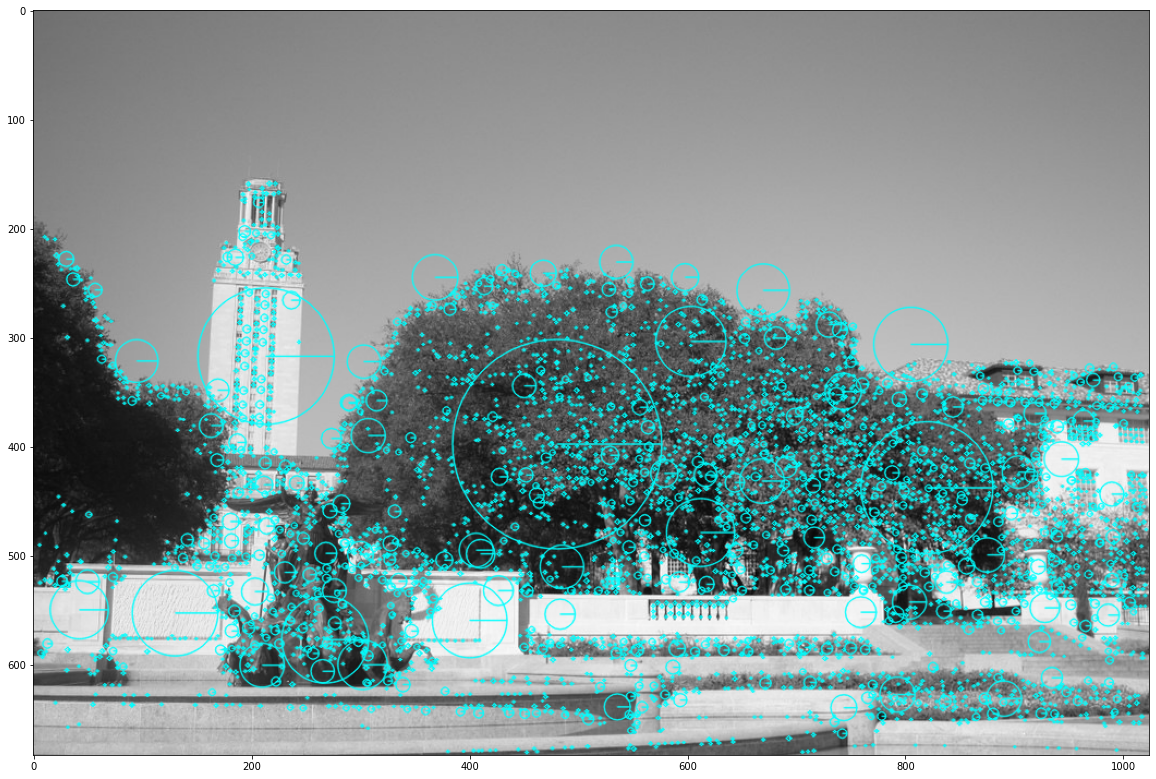

In [10]:
plt.figure(figsize=(20, 20))
plt.imshow(keypoints_image)
plt.show()

---
# 第五部分：SIFT算法的应用（25分）

- 至此，你应该成功实现了SIFT算法的关键步骤，接下来我们将使用实现的SIFT算法在两幅图像中检测特征点，并进行特征点匹配，最终实现简单的图像拼接。
- 输入图像为`left.JPG`和`right.JPG`，你可以在canvas_own中下载。
- 图像拼接的步骤如下：
    - 检测两幅图像的特征点
    - 对两幅图像的特征点进行匹配
    - 估计单应性矩阵
    - 使用单应性矩阵对两幅图像进行拼接
- 请在下面的代码块中实现上述步骤，并展示拼接后的图像。
- 你可以使用openCV的库函数来实现上述步骤。
    - 特征点匹配可参考 https://docs.opencv.org/4.3.0/dc/dc3/tutorial_py_matcher.html 推荐使用第二种，即FLANN based matcher
    - 单应性矩阵的计算可参考 https://docs.opencv.org/4.3.0/d9/dab/tutorial_homography.html （即cv2.findHomography, 使用自己实现的DLT算法可以得到更高分值）
    - 图像拼接可使用cv2.warpPerspective函数

- **注意** ：请你同时用你的SIFT算法和openCV的SIFT算法实现特征点的检测和描述子的构建，并对比两者的结果，讨论效果与速度的差异。
    
- hint: 你可以使用openCV的SIFT算法如下：
    ```python
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    ```

- 评分标准：
    - 特征点匹配：5'
    - 单应性矩阵的计算：调用cv2.findHomography得5分，自己实现DLT算法得10分
    - 图像拼接与展示：5'
    - opencv sift的使用与对比：5' （一两句结论 + 图像对比展示）

In [11]:
"""实现好的匹配点可视化函数，主要用于保存和展示匹配点图像"""

def draw_matches(image1, keypoints1, image2, keypoints2, matches, output_folder=None, img_name="matches.jpg"):
    """Draw matches between two images.
    """
    # convert to uint8
    image1 = image1.astype(np.uint8)
    image2 = image2.astype(np.uint8)
    image_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None)
    if output_folder is not None:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        output_path = os.path.join(output_folder, img_name)
        cv2.imwrite(output_path, image_matches)
    
    # show the image
    # cv2.imshow("matches", image_matches)
    plt.figure(figsize=(20, 20))
    plt.imshow(image_matches)
    plt.axis('off')
    plt.show()

    return image_matches

In [12]:
# find homography matrix

# Code here

# try to implement DLT

# Step1: Calculate A_i Matrix (2 * 9) for each point

def DLT(src_points, dst_points):
    
    data_pairs = []

    for src, dst in zip(src_points, dst_points):
        data_pairs.append([[src[0][0], src[0][1]], [dst[0][0], dst[0][1]]])
    
    for pair in data_pairs:
        pair[0].append(1)
        pair[1].append(1)
        

    A_list = []
    for itemp in data_pairs:
        x_i = np.array(itemp[0])
        x_i_s = itemp[1][0]
        y_i_s = itemp[1][1]
        w_i_s = itemp[1][2]

        A = np.block(
            [
                [np.zeros(3), -w_i_s * x_i, y_i_s * x_i],
                [w_i_s * x_i, np.zeros(3), -x_i_s * x_i],
            ]
        )

        A_list.append(A)

    # Step2: Assemble A Matrix into (2n * 9)

    A_assembled = np.vstack(A_list)


    # Step3: Obtain the SVD of A, the unit singular vector correspponding to the smallest singular value is the solution

    _, _, V = np.linalg.svd(A_assembled) # D is the list of diagonal values, descending order

    # Step4: Extract the solution from V

    h = V[-1, :]
    H = h.reshape(3, 3)
    H = H / H[2,2]

    return H



In [13]:

"""正式的回答区域"""

image1_path = "HW2-data/left.JPG"
image2_path = "HW2-data/right.JPG"
import time

# 1. load the image, grayscale and float32
image1 = cv2.cvtColor(cv2.imread(image1_path), cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(cv2.imread(image2_path), cv2.COLOR_BGR2GRAY)


In [14]:


# resize the image for speed
image1 = cv2.resize(image1, (480, 320))
image2 = cv2.resize(image2, (480, 320))

# 2. compute keypoints and descriptors
# use_your_own_sift = False
# if use_your_own_sift:
print("-" * 10)
print("using your own sift")
print("-" * 10)


own_start = time.time()
keypoints1_own, descriptors1_own = compute_keypoints_and_descriptors(np.float32(image1))
keypoints2_own, descriptors2_own = compute_keypoints_and_descriptors(np.float32(image2))
own_end = time.time()

print(f"own sift time: {own_end - own_start}")

print("-" * 10)
print("using opencv sift")
print("-" * 10)


----------
using your own sift
----------
number of octaves of Gaussian pyramid: 9
----------
got 6 Gaussian kernels: [1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]
----------
got 9 octaves in Gaussian pyramid, and each octave has 6 images
----------


generating descriptors: 100%|██████████| 910/910 [00:16<00:00, 54.17it/s]


number of octaves of Gaussian pyramid: 9
----------
got 6 Gaussian kernels: [1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]
----------
got 9 octaves in Gaussian pyramid, and each octave has 6 images
----------


generating descriptors: 100%|██████████| 773/773 [00:15<00:00, 51.07it/s]

own sift time: 54.02283024787903
----------
using opencv sift
----------


In [15]:

# use opencv sift here
cv2_start = time.time()
sift = cv2.SIFT_create()
keypoints1_cv2, descriptors1_cv2 = sift.detectAndCompute(image1, None)
keypoints2_cv2, descriptors2_cv2 = sift.detectAndCompute(image2, None)
cv2_end = time.time()   

print(f"cv2 sift time: {cv2_end - cv2_start}")


cv2 sift time: 0.04761815071105957


In [16]:
# 3. match
# hint: cv2.FlannBasedMatcher, return matches (list of cv2.DMatch)

index_params = dict(algorithm=1, tree=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches_own = flann.knnMatch(descriptors1_own, descriptors2_own, k=2)
matches_cv2 = flann.knnMatch(descriptors1_cv2, descriptors2_cv2, k=2)

def get_good_matches(matches):
    good_matches = []
    ratio_thresh = 0.4
    for m,n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    return good_matches

matches_own = get_good_matches(matches_own)
matches_cv2 = get_good_matches(matches_cv2)


matches from own SIFT


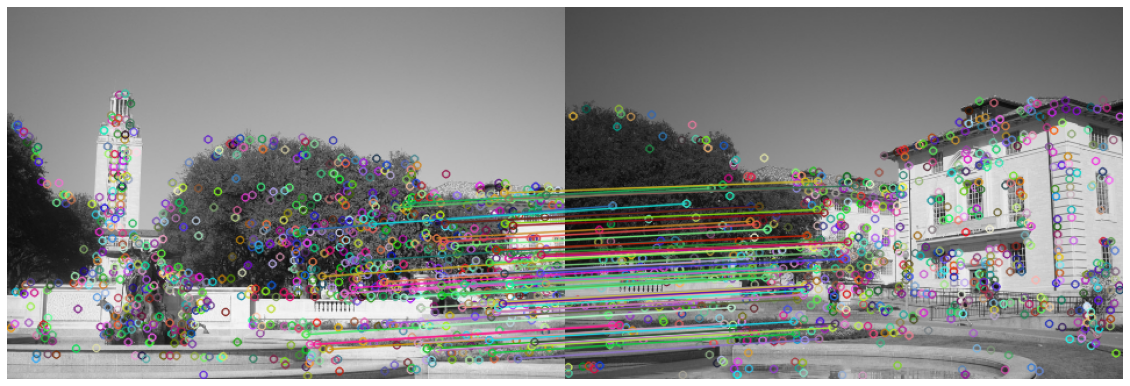

matches from cv2 SIFT


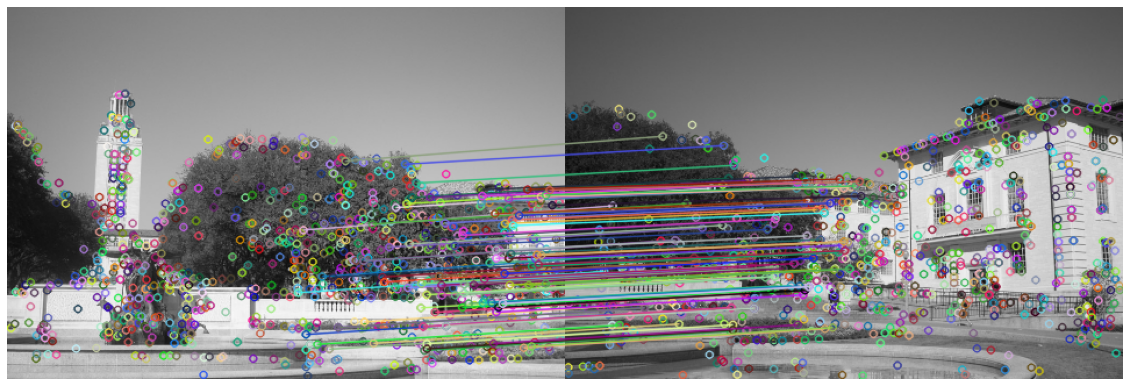

In [17]:
# 4. draw matches
# hint: use codes above, i.e. the draw_matches function
print("matches from own SIFT")
image_matches_own = draw_matches(image1, keypoints1_own, image2, keypoints2_own, matches_own, "output", "matches_own.jpg")

print("matches from cv2 SIFT")
image_matches_cv2 = draw_matches(image1, keypoints1_cv2, image2, keypoints2_cv2, matches_cv2, "output", "matches_cv2.jpg")



In [18]:

# 5. matches to homography
src_pts_own = np.float32([keypoints1_own[m.queryIdx].pt for m in matches_own]).reshape(-1, 1, 2)
dst_pts_own = np.float32([keypoints2_own[m.trainIdx].pt for m in matches_own]).reshape(-1, 1, 2)

src_pts_cv2 = np.float32([keypoints1_cv2[m.queryIdx].pt for m in matches_cv2]).reshape(-1, 1, 2)
dst_pts_cv2 = np.float32([keypoints2_cv2[m.trainIdx].pt for m in matches_cv2]).reshape(-1, 1, 2)

# hint: use cv2.findHomography

# calculate for points derived from self-implementation SIFT

H_own = DLT(src_pts_own, dst_pts_own)
print("From self-implementation DLT")
print(H_own)
print("\n")

print("From cv2.findHomography")
H_cv2_own, _ = cv2.findHomography(src_pts_own, dst_pts_own)
print(H_cv2_own)

From self-implementation DLT
[[ 1.31617509e+00 -7.52448382e-02 -2.73240051e+02]
 [ 1.75779036e-01  1.23368904e+00 -8.15954158e+01]
 [ 6.24598644e-04  5.36483560e-05  1.00000000e+00]]


From cv2.findHomography
[[ 1.30526915e+00 -7.76060452e-02 -2.70051632e+02]
 [ 1.72456191e-01  1.22146661e+00 -7.94413050e+01]
 [ 6.11234528e-04  3.73463500e-05  1.00000000e+00]]


## Use our self-implemented DLT

In [19]:
H_own = DLT(src_pts_own, dst_pts_own)
H_cv2 = DLT(src_pts_cv2, dst_pts_cv2)

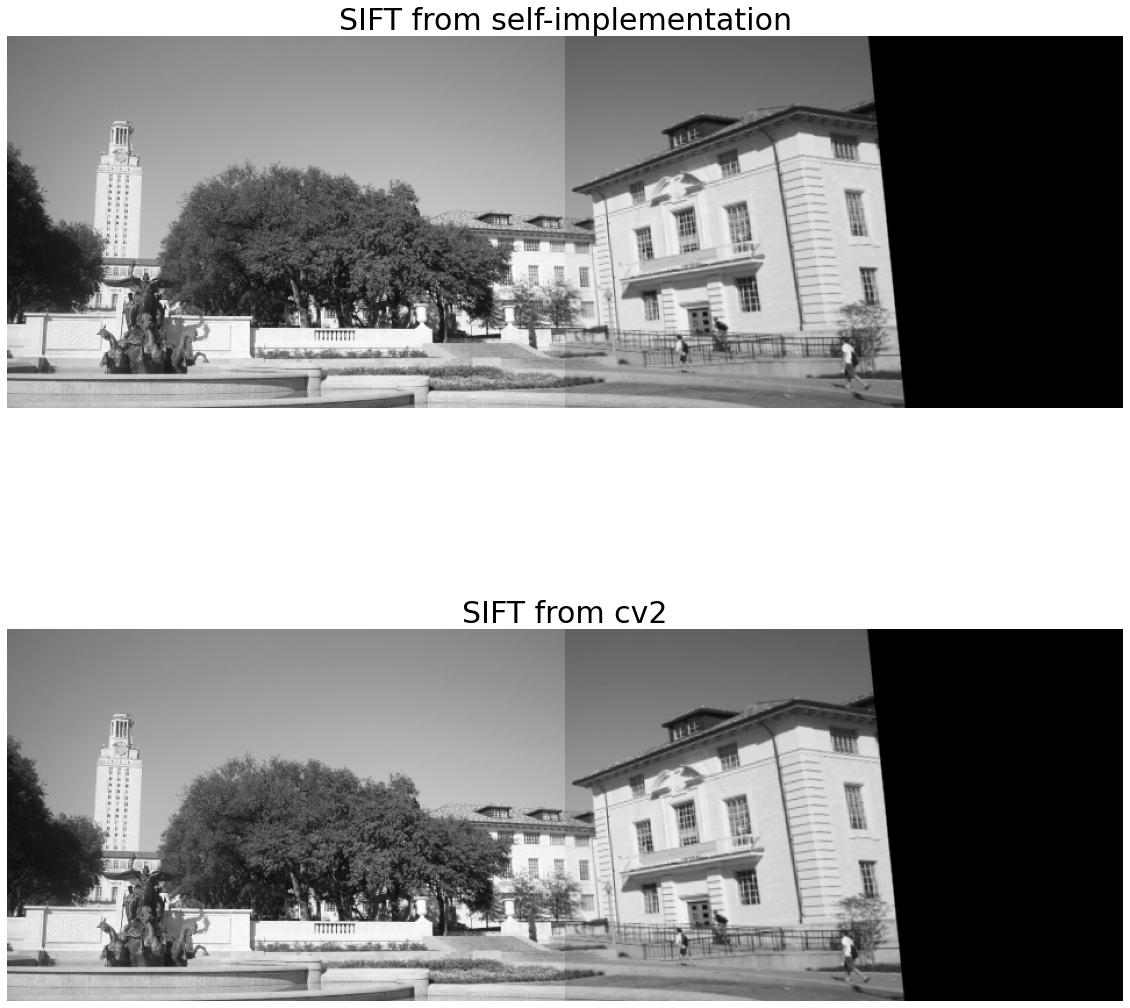

In [20]:
h1, w1 = image1.shape[:2]
h2, w2 = image2.shape[:2]

warped_img_own = cv2.warpPerspective(image2, np.linalg.inv(H_own), (w1 + w2, max(h1, h2)))
warped_image_cv2 = cv2.warpPerspective(image2, np.linalg.inv(H_cv2), (w1 + w2, max(h1, h2)))
h_w, w_w = warped_img_own.shape[:2]

canvas_own = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
canvas_cv2 = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)

canvas_own[0:h1, 0:w1] = image1
canvas_cv2[0:h1, 0:w1] = image1

canvas_own[:h_w, 0:w_w] = np.maximum(canvas_own[0:h_w, 0:w_w], warped_img_own)
canvas_cv2[:h_w, 0:w_w] = np.maximum(canvas_cv2[0:h_w, 0:w_w], warped_image_cv2)


# 7. draw final image
# hint: use cv2.imshow, cv2.imwrite
# cv2.imshow('Stitched Image', canvas_own )

plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.title("SIFT from self-implementation", fontsize=30)
plt.axis('off')
plt.imshow(canvas_own, cmap='gray')
plt.subplot(2, 1, 2)
plt.title("SIFT from cv2", fontsize=30)
plt.imshow(canvas_cv2, cmap='gray')
plt.axis('off')
plt.show()

## Analysis

可以看到，当我们在匹配点中使用0.4作为阈值时，我们自己实现的SIFT和CV2的SIFT效果差距并不大，都能够找到很多优质的匹配点，且从拼接结果来看，效果比较理想。
但是，我们自己实现的SIFT的速度要慢很多，需要 53s 左右 (Macbook M1 Pro 2021)
而CV2的SIFT只需要 0.046 s 左右 